In [3]:
import os
import random
import shutil
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

# Пути
csv_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv"
images_base_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/train"
new_base_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/balanced_train"

# Параметры
target_per_class = 6260  # Целевое количество изображений в каждом классе

# Создание новой папки
os.makedirs(new_base_path, exist_ok=True)
for cls in ['0', '1', '2']:
    os.makedirs(os.path.join(new_base_path, cls), exist_ok=True)

# Чтение CSV
df = pd.read_csv(csv_path)

# Функция для копирования изображений
def copy_image(image_name, label, new_name=None):
    src_path = os.path.join(images_base_path, str(label), image_name)
    dst_name = new_name if new_name else image_name
    dst_path = os.path.join(new_base_path, str(label), dst_name)
    shutil.copy(src_path, dst_path)

# 1. Обработка класса 0 (undersampling)
class0_images = df[df['true_label'] == 0]
selected_class0 = class0_images.sample(n=target_per_class, random_state=42)

# 2. Обработка класса 1 (копируем всё как есть)
class1_images = df[df['true_label'] == 1]

# 3. Обработка класса 2 (oversampling с аугментацией)
class2_images = df[df['true_label'] == 2]

# Аугментации для глазного дна
augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=512, scale=(0.9, 1.1)),  # Теперь 512
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
])

# Сколько аугментированных изображений надо создать
required_augmented = target_per_class - len(class2_images)

# 4. Копируем все выбранные изображения
new_records = []

# Класс 0
for _, row in tqdm(selected_class0.iterrows(), total=len(selected_class0), desc="Copying class 0"):
    copy_image(row['image_name'], 0)
    new_records.append((row['image_name'], 0))

# Класс 1
for _, row in tqdm(class1_images.iterrows(), total=len(class1_images), desc="Copying class 1"):
    copy_image(row['image_name'], 1)
    new_records.append((row['image_name'], 1))

# Класс 2 — копируем оригиналы
for _, row in tqdm(class2_images.iterrows(), total=len(class2_images), desc="Copying class 2 original"):
    copy_image(row['image_name'], 2)
    new_records.append((row['image_name'], 2))

# Класс 2 — создаём аугментации
all_class2_image_names = class2_images['image_name'].tolist()

for i in tqdm(range(required_augmented), desc="Augmenting class 2"):
    # Выбираем случайное изображение
    original_name = random.choice(all_class2_image_names)
    original_path = os.path.join(images_base_path, "2", original_name)
    
    # Открываем и применяем аугментацию
    img = Image.open(original_path).convert('RGB')
    img_aug = augmentations(img)

    # Генерируем новое имя
    new_name = f"aug_{i}_{original_name}"
    save_path = os.path.join(new_base_path, "2", new_name)
    img_aug.save(save_path)
    
    new_records.append((new_name, 2))

# 5. Сохраняем новый CSV
new_df = pd.DataFrame(new_records, columns=['image_name', 'true_label'])
new_csv_path = os.path.join(new_base_path, "balanced_train.csv")
new_df.to_csv(new_csv_path, index=False)

print(f"Готово! Новый датасет сохранён в {new_base_path}")


Augmenting class 2: 100%|██████████| 5761/5761 [01:26<00:00, 66.89it/s]

Готово! Новый датасет сохранён в D:/dataset/_eyepacs/data/filtered_data_with_cosine/balanced_train


            Старые  Новые_оригинал  Аугментации
true_label                                     
0            18867            6260            0
1             6260            6260            0
2              499             499         5761


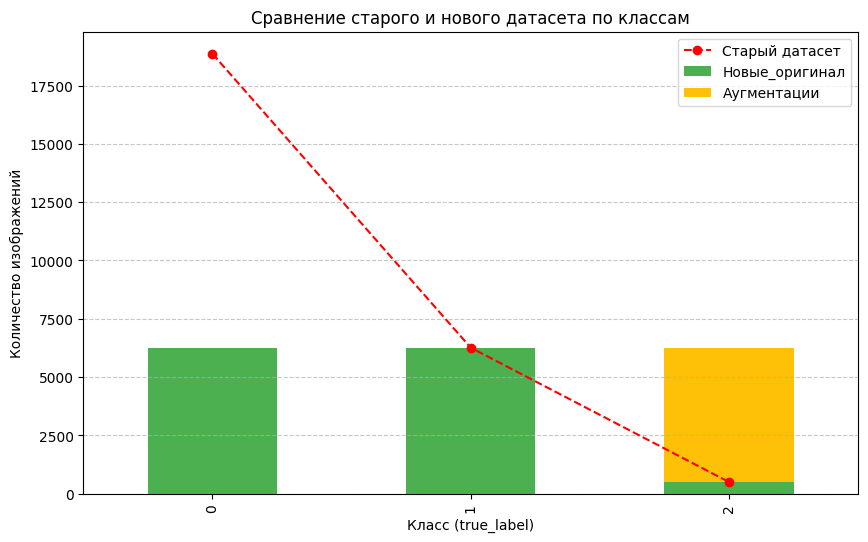

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отметим, какие изображения аугментированы
new_df['augmented'] = new_df['image_name'].apply(lambda x: x.startswith('aug_'))

# Посчитаем:
old_counts = df['true_label'].value_counts().sort_index()
new_original_counts = new_df[~new_df['augmented']]['true_label'].value_counts().sort_index()
new_augmented_counts = new_df[new_df['augmented']]['true_label'].value_counts().sort_index()

# Объединим всё в одну таблицу для удобства
summary_df = pd.DataFrame({
    'Старые': old_counts,
    'Новые_оригинал': new_original_counts,
    'Аугментации': new_augmented_counts
}).fillna(0)  # где нет значений, заполним нулями

summary_df = summary_df.astype(int)  # на всякий случай сделаем целыми числами

print(summary_df)

# Теперь построим stacked bar plot
summary_df[['Новые_оригинал', 'Аугментации']].plot(
    kind='bar',
    stacked=True,
    color=['#4CAF50', '#FFC107'],
    figsize=(10,6)
)

# Добавим отдельно график для старого датасета
plt.plot(summary_df.index, summary_df['Старые'], color='red', marker='o', linestyle='--', label='Старый датасет')

# Оформление
plt.xlabel('Класс (true_label)')
plt.ylabel('Количество изображений')
plt.title('Сравнение старого и нового датасета по классам')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


            Старые  Новые_оригинал  Аугментации
true_label                                     
0            18867           18867            0
1             6260            6260         6260
2              499             499         5761


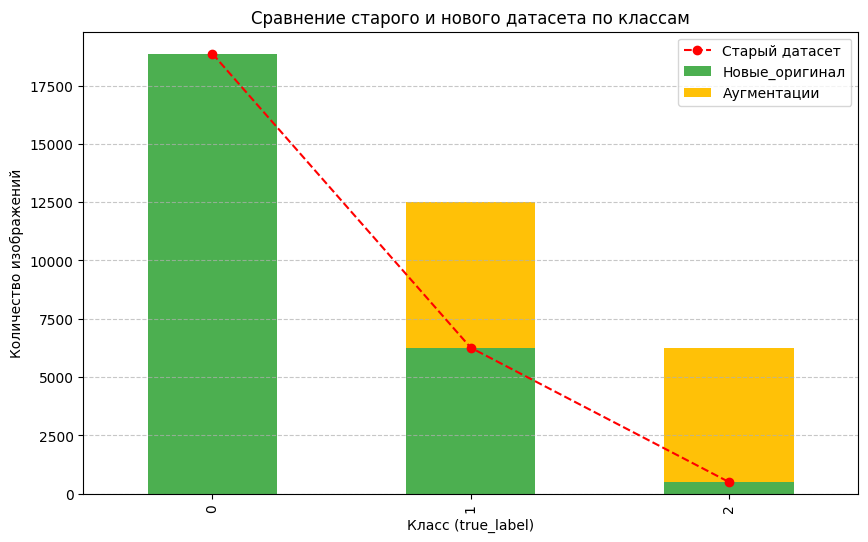

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
new_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_augmented.csv')
csv_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv"
df = pd.read_csv(csv_path)
# Отметим, какие изображения аугментированы
new_df['augmented'] = new_df['image_name'].apply(lambda x: x.startswith('aug_'))

# Посчитаем:
old_counts = df['true_label'].value_counts().sort_index()
new_original_counts = new_df[~new_df['augmented']]['true_label'].value_counts().sort_index()
new_augmented_counts = new_df[new_df['augmented']]['true_label'].value_counts().sort_index()

# Объединим всё в одну таблицу для удобства
summary_df = pd.DataFrame({
    'Старые': old_counts,
    'Новые_оригинал': new_original_counts,
    'Аугментации': new_augmented_counts
}).fillna(0)  # где нет значений, заполним нулями

summary_df = summary_df.astype(int)  # на всякий случай сделаем целыми числами

print(summary_df)

# Теперь построим stacked bar plot
summary_df[['Новые_оригинал', 'Аугментации']].plot(
    kind='bar',
    stacked=True,
    color=['#4CAF50', '#FFC107'],
    figsize=(10,6)
)

# Добавим отдельно график для старого датасета
plt.plot(summary_df.index, summary_df['Старые'], color='red', marker='o', linestyle='--', label='Старый датасет')

# Оформление
plt.xlabel('Класс (true_label)')
plt.ylabel('Количество изображений')
plt.title('Сравнение старого и нового датасета по классам')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


            Старые  Новые_оригинал  Аугментации
true_label                                     
0            18867           18867            0
1             6260            6260            0
2              499             499         5761


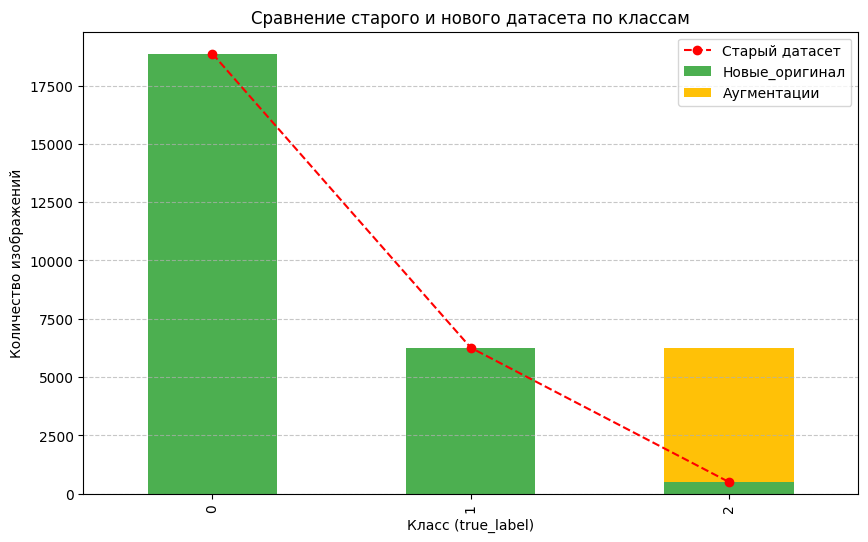

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# new_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_labels_20k_aug.csv')
new_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_20_0_6_2.csv')
csv_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv"
df = pd.read_csv(csv_path)
# Отметим, какие изображения аугментированы
new_df['augmented'] = new_df['image_name'].apply(lambda x: x.startswith('aug_'))

# Посчитаем:
old_counts = df['true_label'].value_counts().sort_index()
new_original_counts = new_df[~new_df['augmented']]['true_label'].value_counts().sort_index()
new_augmented_counts = new_df[new_df['augmented']]['true_label'].value_counts().sort_index()

# Объединим всё в одну таблицу для удобства
summary_df = pd.DataFrame({
    'Старые': old_counts,
    'Новые_оригинал': new_original_counts,
    'Аугментации': new_augmented_counts
}).fillna(0)  # где нет значений, заполним нулями

summary_df = summary_df.astype(int)  # на всякий случай сделаем целыми числами

print(summary_df)

# Теперь построим stacked bar plot
summary_df[['Новые_оригинал', 'Аугментации']].plot(
    kind='bar',
    stacked=True,
    color=['#4CAF50', '#FFC107'],
    figsize=(10,6)
)

# Добавим отдельно график для старого датасета
plt.plot(summary_df.index, summary_df['Старые'], color='red', marker='o', linestyle='--', label='Старый датасет')

# Оформление
plt.xlabel('Класс (true_label)')
plt.ylabel('Количество изображений')
plt.title('Сравнение старого и нового датасета по классам')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
